In [69]:
# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Point to the 'data' folder within your project structure
# Adjust the path below to match your specific folder structure in Google Drive
DATA_DIR = "/content/drive/MyDrive/Data Science Capstone/CODE GA Frog ID/data/processed"

import os, glob

# 🔹 Recursive search: include all files and subfolders within the data directory
audio_files = glob.glob(os.path.join(DATA_DIR, "**", "*.wav"), recursive=True) \
            + glob.glob(os.path.join(DATA_DIR, "**", "*.mp3"), recursive=True) \
            + glob.glob(os.path.join(DATA_DIR, "**", "*.csv"), recursive=True)


print("Found files in data directory:", len(audio_files))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found files in data directory: 1484


In [70]:
from google.colab import userdata
import os

# Retrieve API key from Colab Secrets
wandb_key = userdata.get('WANDB_API_KEY')

if wandb_key:
    os.environ["WANDB_API_KEY"] = wandb_key
    print("✅ W&B API key loaded from Colab Secrets.")
else:
    print("❌ W&B key not found in Colab Secrets. Please add WANDB_API_KEY there.")


✅ W&B API key loaded from Colab Secrets.


In [71]:
# @title 3.1: Load Aggregated Features
import pandas as pd
import os

# Define the path to the aggregated features file
FEATURES_FILE = "/content/drive/MyDrive/Data Science Capstone/CODE GA Frog ID/data/features_aggregated.csv"

# Load the aggregated features into a DataFrame
try:
    qdf = pd.read_csv(FEATURES_FILE)
    print(f"✅ Loaded features from {FEATURES_FILE}")
    print("Extracted features shape:", qdf.shape)
    display(qdf.head())
except FileNotFoundError:
    print(f"❌ Error: {FEATURES_FILE} not found. Please make sure the file exists in the specified directory.")
except Exception as e:
    print(f"❌ An error occurred while loading the features file: {e}")

✅ Loaded features from /content/drive/MyDrive/Data Science Capstone/CODE GA Frog ID/data/features_aggregated.csv
Extracted features shape: (1400, 41)


,file_id,species,processed_path,split,centroid_mean,centroid_std,bandwidth_mean,bandwidth_std,rolloff_mean,rolloff_std,...,mfcc9_std,mfcc10_mean,mfcc10_std,mfcc11_mean,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std,provenance
0,dlg_ggpd_n200-g2-m1-2013-c3-track-75,spring_peeper,data\processed\spring_peeper\dlg_ggpd_n200-g2-...,train,3389.533751,448.455359,1290.690054,475.713106,4054.162569,1559.845084,...,7.123391,11.207035,9.884705,32.316826,11.670345,-21.581337,13.458815,-18.961439,10.910549,"{""run_id"": ""378baa09-a8b9-49d4-b068-e75b54aec8..."
1,mixkit-forest-with-birds-singing-1235,not_frogs,data\processed\not_frogs\mixkit-forest-with-bi...,train,4838.550526,486.265809,1850.390663,274.143165,6604.423250,800.712538,...,10.996724,-1.487953,9.099717,-5.413002,10.777164,-2.586629,10.092809,-3.554329,10.365214,"{""run_id"": ""378baa09-a8b9-49d4-b068-e75b54aec8..."
2,ML183625,american_toad,data\processed\american_toad\ML183625.wav,train,3737.120688,2062.781671,2198.668029,843.678412,5771.497970,3356.389545,...,11.502592,17.037777,18.280851,-5.980760,9.877294,-10.429179,13.155930,3.924512,17.905514,"{""run_id"": ""378baa09-a8b9-49d4-b068-e75b54aec8..."
3,ML209151,american_toad,data\processed\american_toad\ML209151.wav,train,4735.248846,494.826106,2736.395450,274.490867,8274.320655,1180.430710,...,5.486805,31.608242,4.273387,-12.913738,5.831031,-16.400057,4.770678,30.853117,3.404432,"{""run_id"": ""378baa09-a8b9-49d4-b068-e75b54aec8..."
4,ML633952175,spring_peeper,data\processed\spring_peeper\ML633952175.wav,train,3077.918119,65.761010,1332.672412,91.462571,3156.662660,212.180407,...,4.580702,-13.337001,4.602490,32.806438,4.387069,16.056959,4.926806,-27.576960,4.667300,"{""run_id"": ""378baa09-a8b9-49d4-b068-e75b54aec8..."


In [72]:
# --- 3.1 Build feature matrix and labels ---
import numpy as np

# assuming qdf is your processed-only DataFrame
qdf = qdf.dropna()


#X = qdf[["centroid_mean", "bandwidth_mean", "rolloff_mean", "centroid_std"]].values


# Expanded feature set: spectral + MFCCs
feature_cols = [
    "centroid_mean", "centroid_std",
    "bandwidth_mean", "bandwidth_std",
    "rolloff_mean", "rolloff_std",
] + [f"mfcc{i}_mean" for i in range(1, 14)] + [f"mfcc{i}_std" for i in range(1, 14)]

X = qdf[feature_cols].dropna().values


y = qdf["species"].values

print("✅ Feature matrix shape:", X.shape)
print("✅ Labels shape:", y.shape)

✅ Feature matrix shape: (1400, 32)
✅ Labels shape: (1400,)


In [73]:
import wandb
wandb.login(key=os.environ["WANDB_API_KEY"])


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Train: 980 | Val: 210 | Test: 210
Accuracy: 0.633
Macro F1: 0.566
                             precision    recall  f1-score   support

          american_bullfrog       0.41      0.67      0.51        18
              american_toad       0.85      0.81      0.83        27
      bird_voiced_tree_frog       1.00      0.25      0.40         4
        copes_gray_treefrog       0.80      0.76      0.78        21
eastern_narrow_mouthed_toad       0.62      0.36      0.45        14
     eastern_spadefoot_toad       0.50      0.33      0.40         3
               fowlers_toad       1.00      0.33      0.50         6
                 green_frog       0.50      0.54      0.52        13
            green_tree_frog       0.64      0.78      0.70        27
      northern_cricket_frog       0.70      0.88      0.78        24
                  not_frogs       0.50      0.44      0.47        18
              pickerel_frog       0.40      0.25      0.31         8
      southern_leopard_frog       0.

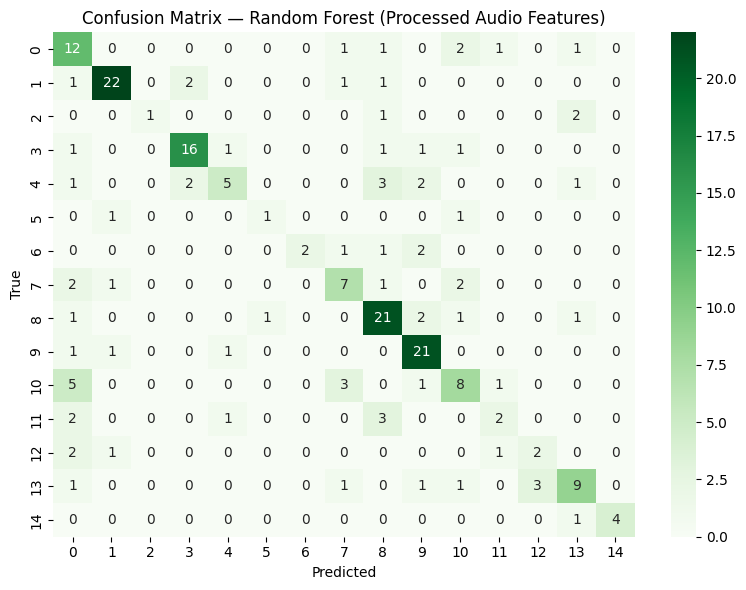

✅ Saved: reports/random_forest_report.csv
✅ Saved: reports/confusion_matrix_rf.png


accuracy,▁
macro_f1,▁
accuracy,0.63333
macro_f1,0.56557


CPU times: user 4.77 s, sys: 114 ms, total: 4.88 s
Wall time: 6.36 s


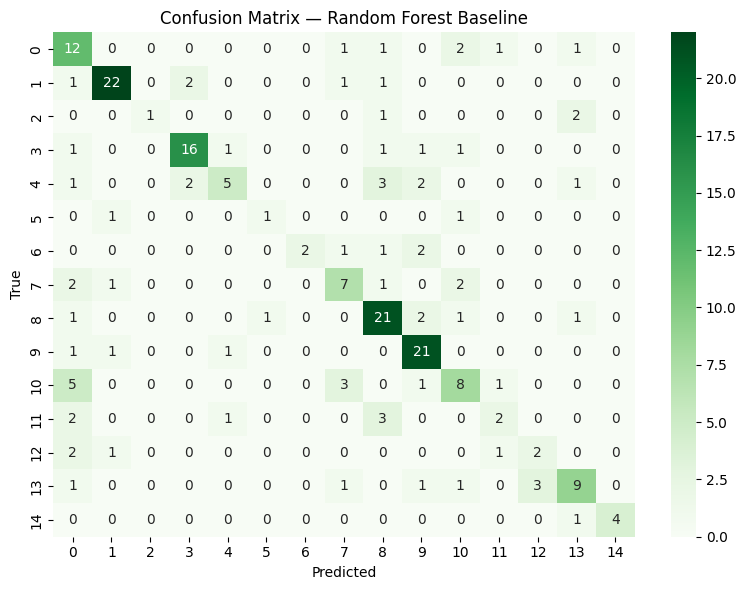

In [74]:
%%time


wandb.init(
    project="georgia-frog-classification",
    name="rf-baseline",
    config={
        "model": "RandomForestClassifier",
        "n_estimators": 200,
        "features": ["centroid_mean","bandwidth_mean","rolloff_mean","centroid_std"],
        "train_split": 0.7,
        "val_split": 0.15,
        "test_split": 0.15
    }
)




# --- 3.2: Train Random Forest Classifier ---

# TRAIN / VALIDATION
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
import wandb
import os, pandas as pd

# 1 Split the processed feature dataset
#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.2, random_state=42, stratify=y
#)


# 1️⃣ Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 2️⃣ Split Temp → Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")




# 3️⃣ Train the Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 4️⃣ Evaluate performance
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy: {acc:.3f}")
print(f"Macro F1: {macro_f1:.3f}")
print(classification_report(y_test, y_pred))


# 5️⃣ Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest (Processed Audio Features)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

# 6️⃣ Save results for your presentation/report
os.makedirs("reports", exist_ok=True)
rep = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(rep).T.to_csv("reports/random_forest_report.csv", index=False)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest Baseline")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("reports/confusion_matrix_rf.png", dpi=150)
print("✅ Saved: reports/random_forest_report.csv")
print("✅ Saved: reports/confusion_matrix_rf.png")



wandb.log({
    "accuracy": acc,
    "macro_f1": macro_f1,
    "confusion_matrix": wandb.Image("reports/confusion_matrix_rf.png")
})

wandb.finish()  # ✅ Close AFTER logging


In [75]:
from time import perf_counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

grid = [50, 100, 200, 400]   # 4 quick experiments
timings = []
for n in grid:
    t0 = perf_counter()
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    dt = perf_counter() - t0
    acc = accuracy_score(y_test, y_pred)
    print(f"{n} trees → acc={acc:.3f}, time={dt:.1f}s")
    timings.append(dt)

print(f"Avg time per run: {sum(timings)/len(timings):.1f}s")


50 trees → acc=0.619, time=0.3s
100 trees → acc=0.629, time=0.7s
200 trees → acc=0.633, time=1.3s
400 trees → acc=0.629, time=2.6s
Avg time per run: 1.2s


In [76]:
import os
os.makedirs("reports", exist_ok=True)


✅ Saved: reports/random_forest_report.csv
✅ Saved: reports/confusion_matrix_rf.png
4.0K	reports/random_forest_report.csv
72K	reports/confusion_matrix_rf.png


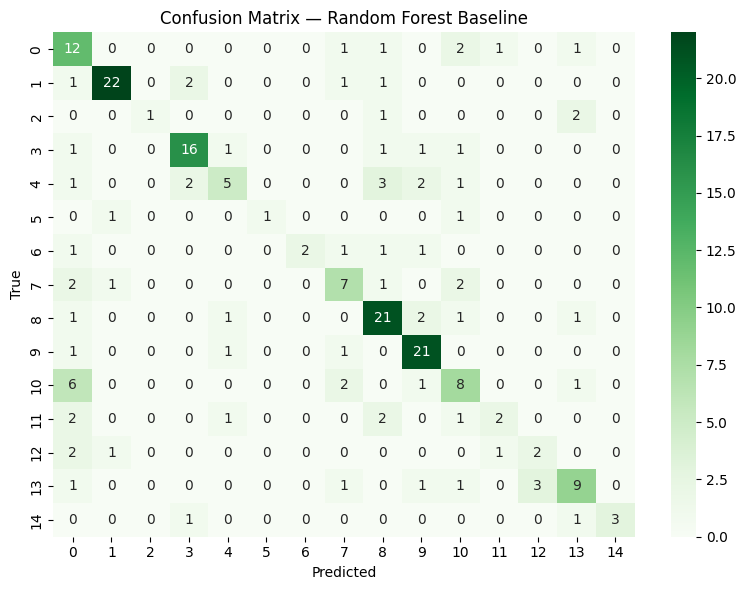

In [77]:
# @title Save Baseline Results for Presentation and Sharing
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import wandb

# 1️⃣ Save numeric classification report
rep = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(rep).T.to_csv("reports/random_forest_report.csv", index=False)
print("✅ Saved: reports/random_forest_report.csv")

# 2️⃣ Save confusion matrix as image
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest Baseline")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("reports/confusion_matrix_rf.png", dpi=150)
print("✅ Saved: reports/confusion_matrix_rf.png")



# 3️⃣ (Optional) Check file sizes for report section
!du -h reports/random_forest_report.csv
!du -h reports/confusion_matrix_rf.png

In [78]:
# @title 3.3: Save Features for Team Use
os.makedirs("reports", exist_ok=True)
qdf.to_csv("reports/frog_audio_quality_features.csv", index=False)
print("💾 Saved reports/frog_audio_quality_features.csv")


💾 Saved reports/frog_audio_quality_features.csv


In [79]:
"""
# Step 1: Import required libraries and load environment variables
# Make sure you have added SUPABASE_URL and SUPABASE_KEY to Colab secrets.
import os
# from dotenv import load_dotenv # No longer needed when using Colab secrets
import pandas as pd
#from supabase import create_client, Client
from google.colab import userdata # Import userdata to access secrets

# Load environment variables
# load_dotenv() # No longer needed when using Colab secrets

# Get Supabase credentials from Colab secrets
#url = userdata.get("SUPABASE_URL")
#key = userdata.get("SUPABASE_KEY")


#if not url or not key:
 #   raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in Colab secrets.")

# Initialize the Supabase client
#supabase: Client = create_client(url, key)

# Step 2: Query the audio_files table from Supabase
# This pulls all metadata for the audio files into a pandas DataFrame.
res = supabase.table("audio_files").select(
    "id,bucket_id,object_name,content_type,size_bytes,created_at,top_level_folder,second_level_folder,species"
).execute()

# Convert to DataFrame
df = pd.DataFrame(res.data)
print(df.head())
"""


'\n# Step 1: Import required libraries and load environment variables\n# Make sure you have added SUPABASE_URL and SUPABASE_KEY to Colab secrets.\nimport os\n# from dotenv import load_dotenv # No longer needed when using Colab secrets\nimport pandas as pd\n#from supabase import create_client, Client\nfrom google.colab import userdata # Import userdata to access secrets\n\n# Load environment variables\n# load_dotenv() # No longer needed when using Colab secrets\n\n# Get Supabase credentials from Colab secrets\n#url = userdata.get("SUPABASE_URL")\n#key = userdata.get("SUPABASE_KEY")\n\n\n#if not url or not key:\n #   raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in Colab secrets.")\n\n# Initialize the Supabase client\n#supabase: Client = create_client(url, key)\n\n# Step 2: Query the audio_files table from Supabase\n# This pulls all metadata for the audio files into a pandas DataFrame.\nres = supabase.table("audio_files").select(\n    "id,bucket_id,object_name,content_type,s

In [80]:
"""# Step 3: Quick inspection of object names
# This helps you understand the folder structure and naming conventions for your audio files.
for obj_name in df['object_name']:
    print(obj_name) """

"# Step 3: Quick inspection of object names\n# This helps you understand the folder structure and naming conventions for your audio files.\nfor obj_name in df['object_name']:\n    print(obj_name) "

In [81]:
# Step 7: Install librosa for audio analysis
# This library is used for feature extraction and visualization of audio files.
%pip install librosa

# Exploratory Data Analysis (EDA) of Frog Audio Files
Let's explore the dataset to understand its structure and key statistics.

In [82]:
"""
# Step 8: Download and analyze a sample audio file
# This demonstrates how to fetch an audio file from Supabase, load it, and visualize its properties.
import librosa
import librosa.display
import matplotlib.pyplot as plt
import io
import requests
import tempfile
import os
from IPython.display import Audio
import numpy as np

# Select the first audio file from the cleaned DataFrame
sample_row = df_clean.iloc[0]
bucket_id = sample_row['bucket_id']
object_name = sample_row['object_name']
print('Analyzing:', object_name)

# Download the audio file from Supabase storage
def download_audio(supabase, bucket_id, object_name):
    public_url_response = supabase.storage.from_(bucket_id).get_public_url(object_name)
    # Handle both dict and string return types
    if isinstance(public_url_response, dict):
        public_url = public_url_response.get('publicUrl')
    else:
        public_url = public_url_response
    if not public_url:
        raise Exception('Could not get public URL for file')
    response = requests.get(public_url)
    response.raise_for_status()
    return response.content

audio_bytes = download_audio(supabase, bucket_id, object_name)

# Save to a temporary file
with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as tmp_file:
    tmp_file.write(audio_bytes)
    tmp_path = tmp_file.name

# Load audio with librosa
y, sr = librosa.load(tmp_path, sr=None)
print(f'Sample rate: {sr}')
print(f'Duration (seconds): {librosa.get_duration(y=y, sr=sr):.2f}')

# Display audio player
Audio(tmp_path)

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Clean up temporary file
os.remove(tmp_path)
"""

"\n# Step 8: Download and analyze a sample audio file\n# This demonstrates how to fetch an audio file from Supabase, load it, and visualize its properties.\nimport librosa\nimport librosa.display\nimport matplotlib.pyplot as plt\nimport io\nimport requests\nimport tempfile\nimport os\nfrom IPython.display import Audio\nimport numpy as np\n\n# Select the first audio file from the cleaned DataFrame\nsample_row = df_clean.iloc[0]\nbucket_id = sample_row['bucket_id']\nobject_name = sample_row['object_name']\nprint('Analyzing:', object_name)\n\n# Download the audio file from Supabase storage\ndef download_audio(supabase, bucket_id, object_name):\n    public_url_response = supabase.storage.from_(bucket_id).get_public_url(object_name)\n    # Handle both dict and string return types\n    if isinstance(public_url_response, dict):\n        public_url = public_url_response.get('publicUrl')\n    else:\n        public_url = public_url_response\n    if not public_url:\n        raise Exception('Could